<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/2-2_Least_error_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 2 - Clasificador por mínimo error**

A continuación, se realiza un clasificador por mínimo error por medio de la **curva ROC**.
<br><br>
Los datasets se generan con una **distribución Gaussiana** (dado una media y una DS). Se realizarán pruebas modificando los parámetros ($\mu$ y $\sigma$).
<br><br>
La calidad de la clasificación en todos los casos se evalúa a partir de los parámetros: **precisión, exactitud y F1-score**.

## **Dataset #1**

Se generan dos datasets con diferente media ($\mu$) y desviación estándar ($\sigma$) con una muestra de 50 cada uno (**N=50 c/u**). Estos dos conjuntos se les asignan etiquetas A y B respectivamente.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86430a74d0>]],
      dtype=object)

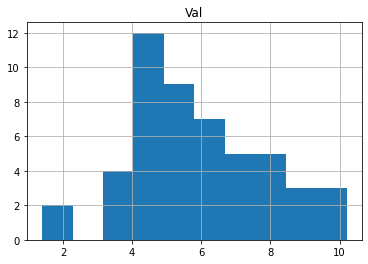

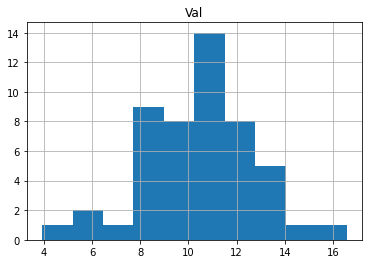

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly as plt

mu1, sigma1 = 6, 2
mu2, sigma2 = 10, 3
N = 50

np.random.seed(1)
label_A = pd.DataFrame(np.random.normal(loc = mu1, scale = sigma1, size = (N,1)),
                        columns=['Val'])
label_A['Etiq'] = 'A'

label_B = pd.DataFrame(np.random.normal(loc = mu2, scale = sigma2, size = (N,1)),
                        columns=['Val'])
label_B['Etiq'] = 'B'

label_A.hist()
label_B.hist()

Se unen los dos dataset en un solo dataframe y se grafica su distribución


,Val,Etiq
0,16.556726,B
1,14.559450,B
2,13.758604,B
3,13.596754,B
4,13.394888,B
...,...,...
95,3.800217,A
96,3.798762,A
97,3.765379,A
98,1.879719,A


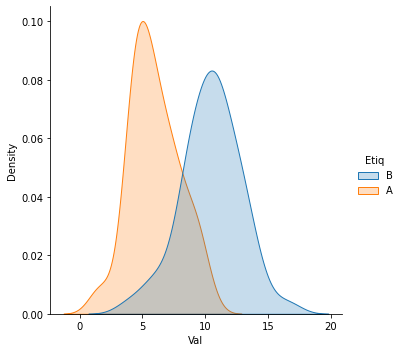

In [ ]:
dataset = pd.concat([label_A, label_B])
dataset = dataset.sort_values(by = 'Val', ascending=False)
dataset = dataset.reset_index().drop('index', axis=1)

sns.displot(data=dataset, x='Val', hue='Etiq', kind='kde', fill=True)
dataset

### **Umbral**

#### 1. Gráfica de la curva ROC. Se asumen como etiqueta TruePositive(TP) como **B** y FalsePositive(FP) como **A**


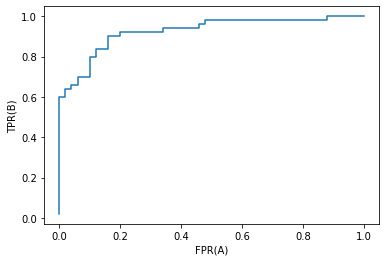

In [ ]:
import matplotlib.pyplot as plt
tpr = []
fpr = []
TP = 0
FP = 0
for row in dataset.itertuples():
  #print(row.Etiq)
  if row.Etiq == 'A':
    FP = FP + 1
  else:
    TP = TP + 1
  tpr.append(TP/N)
  fpr.append(FP/N)

plt.plot(fpr, tpr)
plt.xlabel("FPR(A)")
plt.ylabel("TPR(B)")
plt.show()

#### 2. Línea tangencial a la curva ROC

Se traza una línea de un sistema aleatorio que corte la curva ROC

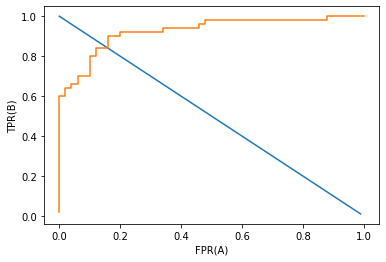

In [ ]:
fpr_thr = np.arange(0.0, 1.0, .01)
tpr_thr = np.arange(1.0, 0.0, -.01)

plt.plot(fpr_thr, tpr_thr)
plt.plot(fpr, tpr)
plt.xlabel("FPR(A)")
plt.ylabel("TPR(B)")

plt.show()  

#### 3. Intersección (umbral de decisión)

El punto de intersección definirá el umbral para el cual se obtiene el mínimo error tanto para la TruePositive Rate (TPR) como para la FalsePositive Rate (FPR)

(array('d', [0.1599999999999999]), array('d', [0.84]))

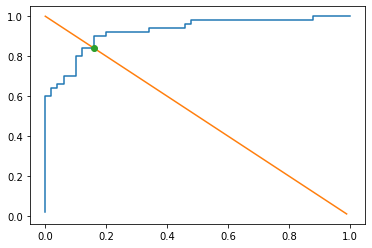

In [ ]:
from shapely.geometry import LineString

plt.plot(fpr, tpr)
plt.plot(fpr_thr, tpr_thr)

# https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value
first_line = LineString(np.column_stack((fpr, tpr)))
second_line = LineString(np.column_stack((fpr_thr, tpr_thr)))

intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o')

intersection.xy

Se obtiene la proporción para el punto encontrado

In [ ]:
# Punto de intersección
umbral_x = round(intersection.xy[0][0], 2)
umbral_y = round(intersection.xy[1][0], 2)

min1 = 1
min2 = 1

umbral_tp = 0
umbral_fp = 0

for i in range(len(tpr)):
  div = i/N
  diff_x = np.abs(div - umbral_x)
  diff_y = np.abs(div - umbral_y)

  if diff_x < min1:
    min1 = diff_x
    umbral_fp = i
  
  if diff_y < min2:
    min2 = diff_y
    umbral_tp = i

print("TPR = {}, es equivalente a: {}/{}".format(umbral_y, umbral_tp, N))
print("FPR = {}, es equivalente a: {}/{}".format(umbral_x, umbral_fp, N))

TPR = 0.84, es equivalente a: 42/50
FPR = 0.16, es equivalente a: 8/50


#### 4. Valor para el umbral

Se busca el valor en la columna "*Val*" del dataset para cuando se cumplen las proporciones mencionadas


In [ ]:
# TruePositive(TP) = B 
# FalsePositive(FP) = A

A_count = 0
B_count = 0
umbral_value = 0
for row in dataset.itertuples():
  if row.Etiq == 'A':
    A_count = A_count + 1
  else:
    B_count = B_count + 1

  if A_count == umbral_fp and B_count == umbral_tp:
    umbral_value = row.Val
    break

print("Para A = {} y B = {}, el valor es {}".format(A_count, B_count, umbral_value))

Para A = 8 y B = 42, el valor es 8.267538884670875


### **Clasificación**
Valores superiores a 8.268 se clasifican como B e inferiores a él se clasifican como A <br><br>
Etiq = A para Val < 8.268<br>
Etiq = B para Val > 8.268

In [ ]:
Etiq_prediccion = []
for row in dataset.itertuples():
  if row.Val > umbral_value:
    Etiq_prediccion.append('B')
  else:
    Etiq_prediccion.append('A')

Se añade la columna de *Etiq_prediccion*

In [ ]:
dataset['Etiq_prediccion'] = Etiq_prediccion
dataset

,Val,Etiq,Etiq_prediccion
0,16.556726,B,B
1,14.559450,B,B
2,13.758604,B,B
3,13.596754,B,B
4,13.394888,B,B
...,...,...,...
95,3.800217,A,A
96,3.798762,A,A
97,3.765379,A,A
98,1.879719,A,A


### **Evaluación**



#### 1. Confusion matrix

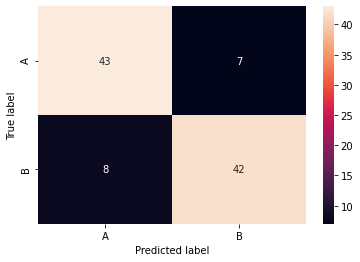

In [ ]:
import matplotlib.pyplot as plt

y_actual = dataset['Etiq']
y_prediccion = dataset['Etiq_prediccion']

confusion_matrix = pd.crosstab(y_actual, y_prediccion, rownames=['True label'], colnames=['Predicted label'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

#### 2. Parámetros de calidad

**Exactitud** = $\frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}$
<br><br>
**Precision** = $\frac{\text{TP}}{\text{TP + FP}}$
<br><br>
**Recall** = $\frac{\text{TP}}{\text{TP + FN}}$
<br><br>
**F1-Score** = $\frac{2\text{(Precision)(Recall)}}{\text{Precision + Recall}}$

In [ ]:
# Se obtienen la cuenta para cada condicion
TP_count = confusion_matrix.iloc[0]['A']
FN_count = confusion_matrix.iloc[0]['B']
FP_count = confusion_matrix.iloc[1]['A']
TN_count = confusion_matrix.iloc[1]['B']


exactitud = (TP_count + TN_count) / (TP_count + TN_count + FN_count + FP_count)
precision = (TP_count) / (TP_count + FP_count)
recall = (TP_count) / (TP_count + FN_count)
F1_score = (2*precision*recall) / (precision + recall)

print("Exactitud = " + str(exactitud))
print("Precision = " + str(precision))
print("F1-Score = " + str(F1_score))

Exactitud = 0.85
Precision = 0.8431372549019608
F1-Score = 0.8514851485148515


#### 3. Reporte con *sklearn*

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset['Etiq'], dataset['Etiq_prediccion']))

              precision    recall  f1-score   support

           A       0.84      0.86      0.85        50
           B       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



Dados los parámetros mostrados al generar los datos, el clasificador arroja una **exactitud y precisión del 85%**

## **Dataset #2**

Ahora se modifican las medias ($\mu$) de los dos grupos de datos para que estas se encuentren más cerca. Se mantiene la misma DS ($\sigma$)

,Val,Etiq
0,13.556726,B
1,11.559450,B
2,10.758604,B
3,10.596754,B
4,10.394888,B
...,...,...
95,2.810511,B
96,2.667659,B
97,1.879719,A
98,1.396923,A


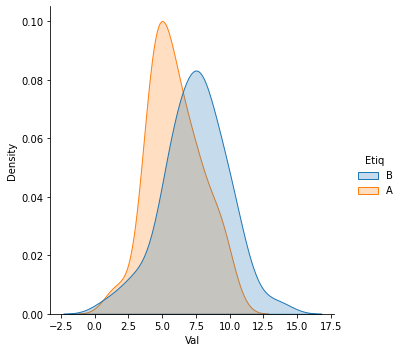

In [ ]:
mu3 = 6
mu4 = 7
N = 50

# Creación de datos
np.random.seed(1)
label2_A = pd.DataFrame(np.random.normal(loc = mu3, scale = sigma1, size = (N,1)),
                        columns=['Val'])
label2_A['Etiq'] = 'A'

label2_B = pd.DataFrame(np.random.normal(loc = mu4, scale = sigma2, size = (N,1)),
                        columns=['Val'])
label2_B['Etiq'] = 'B'

# Union de los datos A y B
dataset2 = pd.concat([label2_A, label2_B])
dataset2 = dataset2.sort_values(by = 'Val', ascending=False)
dataset2 = dataset2.reset_index().drop('index', axis=1)

sns.displot(data=dataset2, x='Val', hue='Etiq', kind='kde', fill=True)
dataset2

### **Umbral**

Se obtiene el punto de intersección para el clasificador

(array('d', [0.35999999999999965]), array('d', [0.64]))

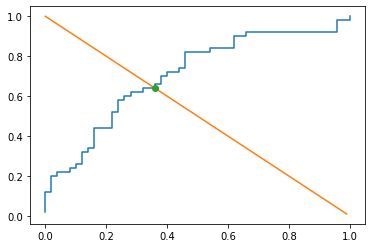

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

tpr = []
fpr = []
TP = 0
FP = 0

# Datos para la curva ROC
for row in dataset2.itertuples():
  #print(row.Etiq)
  if row.Etiq == 'A':
    FP = FP + 1
  else:
    TP = TP + 1
  tpr.append(TP/N)
  fpr.append(FP/N)

# Linea de 45° para el punto umbral
fpr_thr = np.arange(0.0, 1.0, .01)
tpr_thr = np.arange(1.0, 0.0, -.01)

# Gráfico de la curva ROC y linea de 45°
plt.plot(fpr, tpr)
plt.plot(fpr_thr, tpr_thr)

# Punto de intersección
# https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value
first_line = LineString(np.column_stack((fpr, tpr)))
second_line = LineString(np.column_stack((fpr_thr, tpr_thr)))
intersection = first_line.intersection(second_line)
if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o')

# Coordenadas de intersección
intersection.xy

In [ ]:
# Punto de intersección
umbral_x = round(intersection.xy[0][0], 2)
umbral_y = round(intersection.xy[1][0], 2)

min1 = 1
min2 = 1
umbral_tp = 0
umbral_fp = 0

# Busqueda de la proporción correspondiente al punto de intersección
for i in range(len(tpr)):
  div = i/N
  diff_x = np.abs(div - umbral_x)
  diff_y = np.abs(div - umbral_y)

  if diff_x < min1:
    min1 = diff_x
    umbral_fp = i
  
  if diff_y < min2:
    min2 = diff_y
    umbral_tp = i

print("TPR = {}, es equivalente a: {}/{}".format(umbral_y, umbral_tp, N))
print("FPR = {}, es equivalente a: {}/{}".format(umbral_x, umbral_fp, N))

# Búsqueda del valor 'Val' en el dataset
#     TruePositive(TP) = B 
#     FalsePositive(FP) = A
A_count = 0
B_count = 0
umbral_value = 0
for row in dataset2.itertuples():
  if row.Etiq == 'A':
    A_count = A_count + 1
  else:
    B_count = B_count + 1

  if A_count == umbral_fp and B_count == umbral_tp:
    umbral_value = row.Val
    break

print("Para A = {} y B = {}, el valor es {}".format(A_count, B_count, umbral_value))

TPR = 0.64, es equivalente a: 32/50
FPR = 0.36, es equivalente a: 18/50
Para A = 18 y B = 32, el valor es 6.468831395634185


### **Clasificación**

Etiq = A para Val < 6.469<br>
Etiq = B para Val > 6.469

In [ ]:
# Se clasifica según el umbral encontrado
Etiq_prediccion = []
for row in dataset2.itertuples():
  if row.Val > umbral_value:
    Etiq_prediccion.append('B')
  else:
    Etiq_prediccion.append('A')

# Se añade la predicción al dataset
dataset2['Etiq_prediccion'] = Etiq_prediccion
dataset2

,Val,Etiq,Etiq_prediccion
0,13.556726,B,B
1,11.559450,B,B
2,10.758604,B,B
3,10.596754,B,B
4,10.394888,B,B
...,...,...,...
95,2.810511,B,A
96,2.667659,B,A
97,1.879719,A,A
98,1.396923,A,A


### **Evaluación**

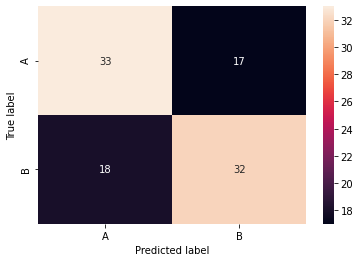


Exactitud = 0.65
Precision = 0.6470588235294118
F1-Score = 0.6534653465346535

              precision    recall  f1-score   support

           A       0.65      0.66      0.65        50
           B       0.65      0.64      0.65        50

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.65      0.65      0.65       100



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

y_actual = dataset2['Etiq']
y_prediccion = dataset2['Etiq_prediccion']

# Matriz de confusión
confusion_matrix2 = pd.crosstab(y_actual, y_prediccion, rownames=['True label'], colnames=['Predicted label'])
sns.heatmap(confusion_matrix2, annot=True)
plt.show()

# Se obtienen la cuenta para cada condicion
TP_count = confusion_matrix2.iloc[0]['A']
FN_count = confusion_matrix2.iloc[0]['B']
FP_count = confusion_matrix2.iloc[1]['A']
TN_count = confusion_matrix2.iloc[1]['B']

# Parámetros de calidad
exactitud = (TP_count + TN_count) / (TP_count + TN_count + FN_count + FP_count)
precision = (TP_count) / (TP_count + FP_count)
recall = (TP_count) / (TP_count + FN_count)
F1_score = (2*precision*recall) / (precision + recall)

# Resultados
print("\nExactitud = " + str(exactitud))
print("Precision = " + str(precision))
print("F1-Score = " + str(F1_score) + "\n")

# Resumen Sklearn
print(classification_report(dataset2['Etiq'], dataset2['Etiq_prediccion']))

Dados los parámetros mostrados al generar los datos, el clasificador arroja una **exactitud y precisión del 65%**

## **Dataset #3**

Se mantiene la misma media ($\mu$) del dataset #1 y ahora se disminuye la DS ($\sigma$) para los grupos A y B 

,Val,Etiq
0,13.278363,B
1,12.279725,B
2,11.879302,B
3,11.798377,B
4,11.697444,B
...,...,...
95,4.900109,A
96,4.899381,A
97,4.882690,A
98,3.939859,A


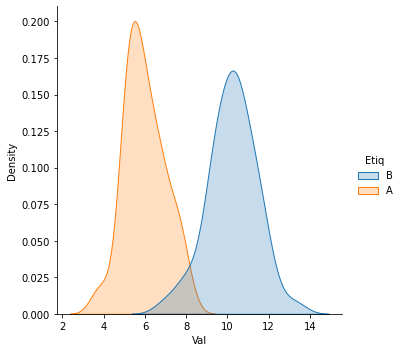

In [ ]:
sigma3 = 1
sigma4 = 1.5
N = 50

# Creación de datos
np.random.seed(1)
label3_A = pd.DataFrame(np.random.normal(loc = mu1, scale = sigma3, size = (N,1)),
                        columns=['Val'])
label3_A['Etiq'] = 'A'

label3_B = pd.DataFrame(np.random.normal(loc = mu2, scale = sigma4, size = (N,1)),
                        columns=['Val'])
label3_B['Etiq'] = 'B'

# Union de los datos A y B
dataset3 = pd.concat([label3_A, label3_B])
dataset3 = dataset3.sort_values(by = 'Val', ascending=False)
dataset3 = dataset3.reset_index().drop('index', axis=1)

sns.displot(data=dataset3, x='Val', hue='Etiq', kind='kde', fill=True)
dataset3

### **Umbral**

TPR = 0.98, es equivalente a: 49/50
FPR = 0.02, es equivalente a: 1/50
Para A = 1 y B = 49, el valor es 7.833829291855616


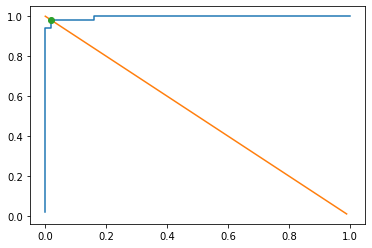

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

tpr = []
fpr = []
TP = 0
FP = 0

# Datos para la curva ROC
for row in dataset3.itertuples():
  #print(row.Etiq)
  if row.Etiq == 'A':
    FP = FP + 1
  else:
    TP = TP + 1
  tpr.append(TP/N)
  fpr.append(FP/N)

# Linea de 45° para el punto umbral
fpr_thr = np.arange(0.0, 1.0, .01)
tpr_thr = np.arange(1.0, 0.0, -.01)

# Gráfico de la curva ROC y linea de 45°
plt.plot(fpr, tpr)
plt.plot(fpr_thr, tpr_thr)

# Punto de intersección
# https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value
first_line = LineString(np.column_stack((fpr, tpr)))
second_line = LineString(np.column_stack((fpr_thr, tpr_thr)))
intersection = first_line.intersection(second_line)
if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o')

# Coordenadas de intersección
intersection.xy

# Punto de intersección
umbral_x = round(intersection.xy[0][0], 2)
umbral_y = round(intersection.xy[1][0], 2)

min1 = 1
min2 = 1
umbral_tp = 0
umbral_fp = 0

# Busqueda de la proporción correspondiente al punto de intersección
for i in range(len(tpr)):
  div = i/N
  diff_x = np.abs(div - umbral_x)
  diff_y = np.abs(div - umbral_y)

  if diff_x < min1:
    min1 = diff_x
    umbral_fp = i
  
  if diff_y < min2:
    min2 = diff_y
    umbral_tp = i

print("TPR = {}, es equivalente a: {}/{}".format(umbral_y, umbral_tp, N))
print("FPR = {}, es equivalente a: {}/{}".format(umbral_x, umbral_fp, N))

# Búsqueda del valor 'Val' en el dataset
#     TruePositive(TP) = B 
#     FalsePositive(FP) = A
A_count = 0
B_count = 0
umbral_value = 0
for row in dataset3.itertuples():
  if row.Etiq == 'A':
    A_count = A_count + 1
  else:
    B_count = B_count + 1

  if A_count == umbral_fp and B_count == umbral_tp:
    umbral_value = row.Val
    break

print("Para A = {} y B = {}, el valor es {}".format(A_count, B_count, umbral_value))

### **Clasificación y evaluación**

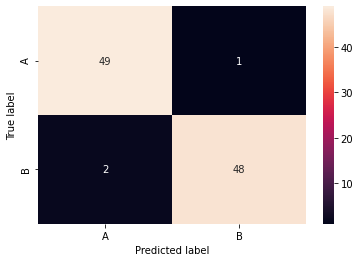


Exactitud = 0.97
Precision = 0.9607843137254902
F1-Score = 0.9702970297029702

              precision    recall  f1-score   support

           A       0.96      0.98      0.97        50
           B       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Se clasifica según el umbral encontrado
Etiq_prediccion = []
for row in dataset3.itertuples():
  if row.Val > umbral_value:
    Etiq_prediccion.append('B')
  else:
    Etiq_prediccion.append('A')

# Se añade la predicción al dataset
dataset3['Etiq_prediccion'] = Etiq_prediccion

y_actual = dataset3['Etiq']
y_prediccion = dataset3['Etiq_prediccion']

# Matriz de confusión
confusion_matrix3 = pd.crosstab(y_actual, y_prediccion, rownames=['True label'], colnames=['Predicted label'])
sns.heatmap(confusion_matrix3, annot=True)
plt.show()

# Se obtienen la cuenta para cada condicion
TP_count = confusion_matrix3.iloc[0]['A']
FN_count = confusion_matrix3.iloc[0]['B']
FP_count = confusion_matrix3.iloc[1]['A']
TN_count = confusion_matrix3.iloc[1]['B']

# Parámetros de calidad
exactitud = (TP_count + TN_count) / (TP_count + TN_count + FN_count + FP_count)
precision = (TP_count) / (TP_count + FP_count)
recall = (TP_count) / (TP_count + FN_count)
F1_score = (2*precision*recall) / (precision + recall)

# Resultados
print("\nExactitud = " + str(exactitud))
print("Precision = " + str(precision))
print("F1-Score = " + str(F1_score) + "\n")

# Resumen Sklearn
print(classification_report(dataset3['Etiq'], dataset3['Etiq_prediccion']))

Dados los parámetros mostrados al generar los datos, el clasificador arroja una **exactitud y precisión del 97%**

## **Resumen**

A continuación, se presentan las distribuciones de los tres datasets vistos y los resultados del clasificador implementado.

Text(0.5, 1.0, 'Dataset #3, Evaluación = 0.97')

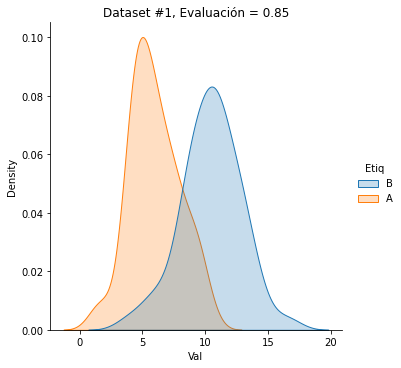

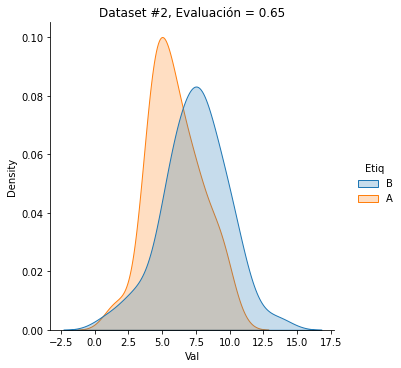

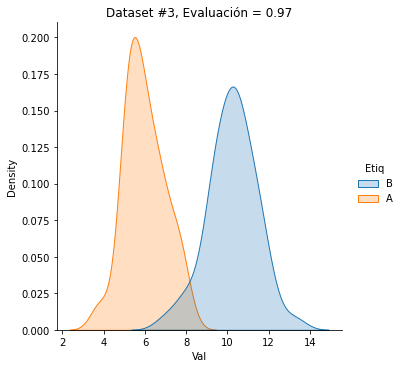

In [ ]:
sns.displot(data=dataset, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title("Dataset #1, Evaluación = 0.85")

sns.displot(data=dataset2, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title("Dataset #2, Evaluación = 0.65")

sns.displot(data=dataset3, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title("Dataset #3, Evaluación = 0.97")

* Como se observa, entre más distantes se encuentres distribuidos los datos, el clasificador presenta un mejor resultado por este método. Esto se debe a que entre menos solapadas las distribuciones, la curva ROC se aleja de la recta aleatoria y por ende es menos complejo distinguir entre las etiquetas A y B. 

* En este caso, el clasificador se escogió de manera que exista el mínimo error tanto para la tasa de falsos positivos como de verdaderos positivos. Sin embargo, dependiendo de la aplicación y contexto, el umbral se puede extraer de diferentes maneras para atender a una mayor precisión o recall.